In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
from tensorflow import keras

In [3]:
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

In [5]:
np.random.seed(1337)

In [6]:
(X_train, _), (X_test, _) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
image_size = X_train.shape[1]
print(image_size)

28


In [8]:
X_train = np.reshape(X_train, (-1, image_size, image_size, 1))
X_train = X_train.astype('float32') / 255

X_test = np.reshape(X_test, (-1, image_size, image_size, 1))
X_test = X_test.astype('float32') / 255

In [9]:
X_train.shape

(60000, 28, 28, 1)

In [10]:
X_test.shape

(10000, 28, 28, 1)

In [12]:
noise = np.random.normal(loc=0.5, scale=0.5, size=X_train.shape)
X_train_noisy = X_train + noise

noise = np.random.normal(loc=0.5, scale=0.5, size=X_test.shape)
X_test_noisy = X_test + noise

# We will cut off the values that fell out of the range [0,1] after adding the noise
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

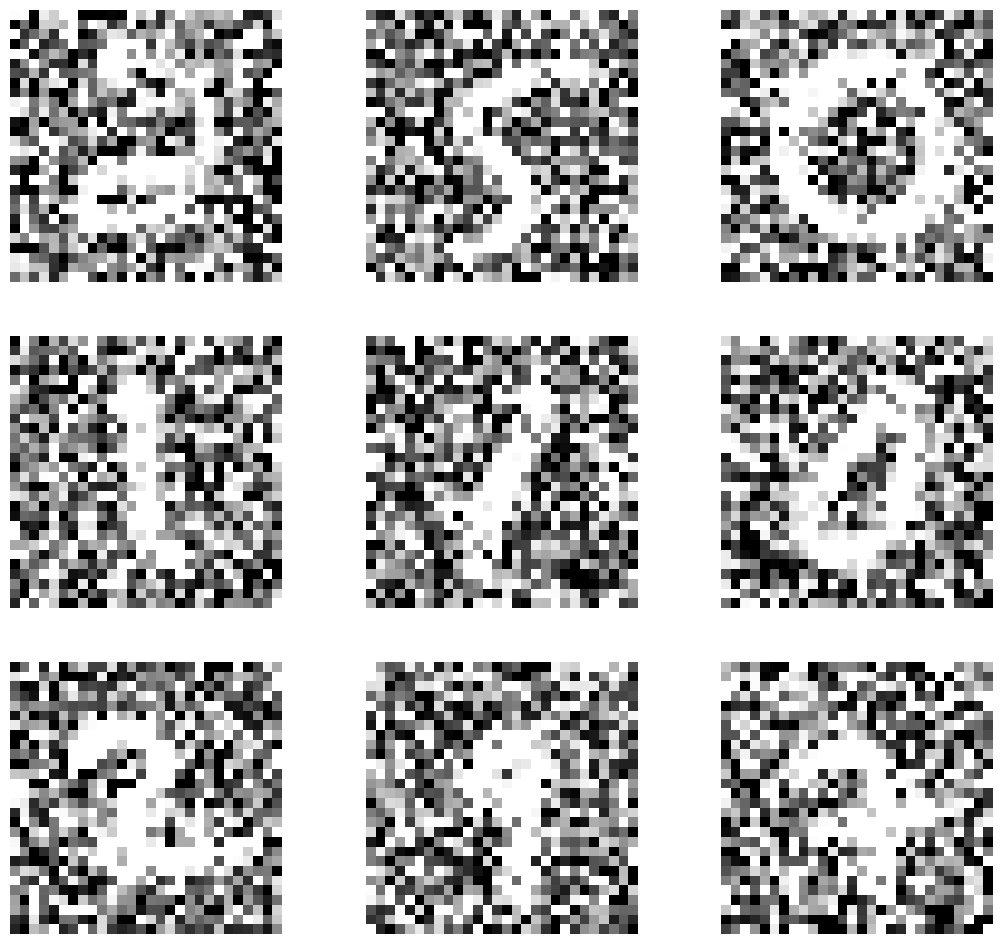

In [13]:
nrows = 3
ncols = 3

# We prepare a panel for drawing each of the images
fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(13, 12)

# We extract nrows*ncols images at random
ix = np.random.randint(low=0, high=X_train_noisy.shape[0], size=nrows*ncols)
chosen_imgs = X_train_noisy[ix]

# We plot each image separately
i = 0
for row in ax:
    for col in row:
        # Before displaying them we change the dimension of each image from (image_size,image_size,1)
        # to (image_size, image_size) as this is required by matplotlib
        img = chosen_imgs[i].reshape(image_size, image_size)
        col.imshow(img, cmap='gray')
        col.axis('off')
        i += 1
        
plt.show()       

In [14]:
input_shape = (image_size, image_size, 1)
latent_dim = 16

In [15]:
# Kernel size
kernel_size = 3

# Number of filters in convolutional layers
layer_filters = [32, 64]